# Vision Transformer (ViT) 

Minimalist implemantation of Vision Transformer for classification.

The dataset used will be a subset of the Intel Scene Classification Challenge to keep it simple and colab-friendly, minor changes can be made to use any other dataset.


## [Paper](https://arxiv.org/abs/2010.11929)


In [1]:
import time
import torch
import torchvision
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score
from torch.utils.data.dataloader import DataLoader

# Fix random seed
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")


Using cuda:0


## Datasets

In [2]:
# Commands to download and prepare scene classification data from:
# https://drive.google.com/file/d/1XPoT-4enxMXer5ZWRXwCVR0W-fObkOhT/view?usp=sharing

! gdown --id 1XPoT-4enxMXer5ZWRXwCVR0W-fObkOhT --output scene_classification.zip

! unzip -q scene_classification.zip
! rm scene_classification.zip

Downloading...
From: https://drive.google.com/uc?id=1XPoT-4enxMXer5ZWRXwCVR0W-fObkOhT
To: /content/scene_classification.zip
253MB [00:03, 69.9MB/s]


In [3]:
IMAGE_SIZE = 128

# Review transforms for other datasets
train_transform = transforms.Compose(
    [
        transforms.Resize((150, 150)),
        transforms.RandomCrop(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
    ]
)

test_transform = transforms.Compose(
    [transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()]
)

train_images = ImageFolder(
    root="train_set", transform=train_transform
)

test_images = ImageFolder(
    root="test_set", transform=test_transform
)

classes = train_images.classes
N_CLASSES = len(classes)


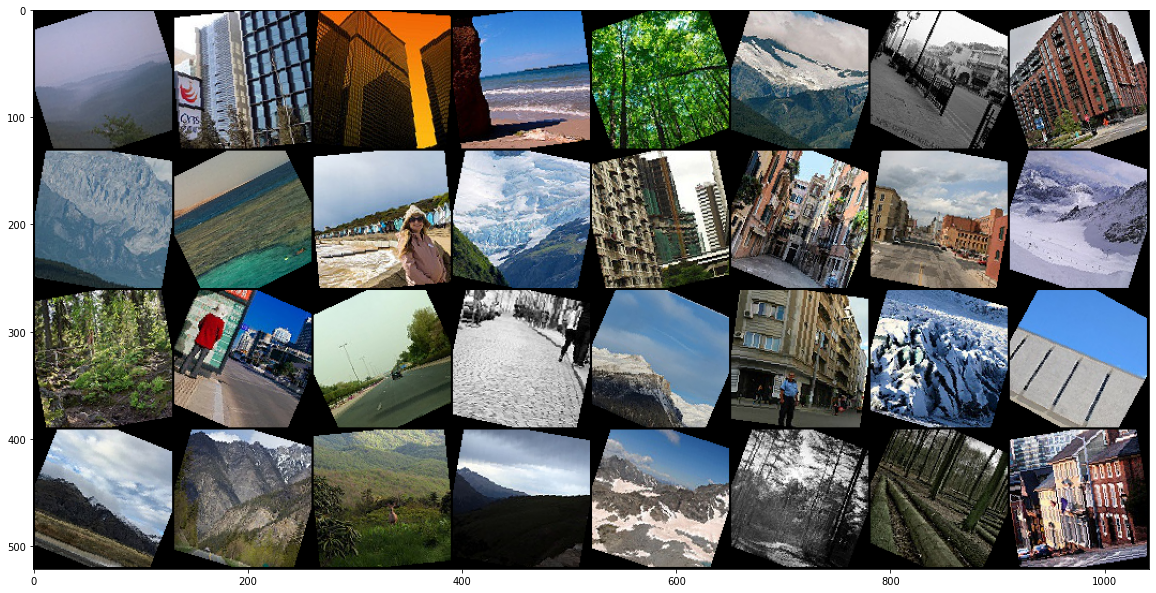

In [4]:
# Show some images
def show_image(image, title):
    image = image.numpy().transpose((1, 2, 0))
    plt.imshow(image)
    plt.title(title)
    plt.show()


# Get a batch of training data
example_images_loader = DataLoader(train_images, batch_size=32, shuffle=True)
sample, labels = next(iter(example_images_loader))
# Increase plot size
plt.rcParams["figure.figsize"] = [20, 15]

sample = torchvision.utils.make_grid(sample)
show_image(sample, title="")


## Model Definition




In [5]:
class ExtractImagePatches(nn.Module):
    """
    Extracts square image patches from a given image.

    Parameters
    ----------
    patch_size: int
      Size of the square patches
    image_size: int
      Size of the images (assumed to be squared too)

    Returns
    -------
    Tensor of shape [bz, num_patches, num_channels, patch_size, patch_size].
    """

    def __init__(self, patch_size, image_size):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size)  ** 2

    def forward(self, x):
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(
            3, self.patch_size, self.patch_size
        )
        patches = patches.reshape(
            x.shape[0],
            self.num_patches,
            x.shape[1],
            self.patch_size,
            self.patch_size,
        )

        return patches


In [6]:
class PatchEncoder(nn.Module):
    """
    Takes a tensor of image patches and returns their linear projection + positional embeddings.
    Also adds [CLS] token.

    Parameters
    ----------
    num_patches: int
      Number of images patches extracted from the input images.
    patch_size: int
      Linear projection size of the square image patches (ie. 32*32*3).
    projection_dim: int
      Linear projection dimension of the image patches.
    """

    def __init__(self, num_patches, patch_size, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.projection_layer = nn.Linear(
            in_features=patch_size, out_features=projection_dim
        )
        self.positional_embeds = nn.Embedding(
            num_embeddings=self.num_patches, embedding_dim=self.projection_dim
        )

    def forward(self, x):
        positions = torch.arange(0, self.num_patches, device=x.device)
        encoded = self.projection_layer(
            x.flatten(start_dim=2)
        ) + self.positional_embeds(positions).repeat(x.shape[0], 1, 1)

        return encoded


In [7]:
class VisionTransformer(nn.Module):
    """
    Vision Transformer (ViT) Implementation. Includes patch extractor and encoder.

    Parameters
    ----------
    num_classes: int
      Number of output classes.
    projection_dim: int
      Dimension of the inputs to the transformer.
    num_heads: int
      Number of attention heads.
    num_layers: int
      Number of transformer-encoder layers.
    patch_size: int
      Size of the image patches (eg., 32, 16, etc.).
    num_patches: int
      Number of patches extracted from an image.
    image_size: int
      Height and width of the image (assumed squared for this implementation).
    num_channels: int
      Number of image channels (i.e., 3 for RGB images).
    reduction: str, default: "mean"
      How to reduce the transformer outputs to feed to the MLP classification head.
      One of:
         "mean": reduce by taking the mean over the sequence length
         "cls": reduce by using the CLS token as in the paper.
    """

    def __init__(
        self,
        num_classes,
        projection_dim,
        num_heads,
        num_layers,
        patch_size,
        num_patches,
        image_size,
        num_channels,
        reduction="mean"
    ):
        super().__init__()
        self.reduction = reduction
        self.cls_token = nn.Parameter(torch.randn(1, 1, projection_dim))
        
        # Define patch extractor + encoder 
        self.patch_extractor = ExtractImagePatches(patch_size, image_size)
        self.encoder = PatchEncoder(
            num_patches=num_patches,
            patch_size=patch_size * patch_size * num_channels,
            projection_dim=projection_dim,
        )

        # Define transformer layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=projection_dim,
            nhead=num_heads,
            dim_feedforward=2048,
            batch_first=True,
            activation="gelu",
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer, num_layers=num_layers
        )

        # Classification head (mlp)
        self.mlp = nn.Sequential(
            nn.LayerNorm(projection_dim),
            nn.Linear(projection_dim, projection_dim // 2),
            nn.GELU(),
            nn.Linear(projection_dim // 2, num_classes)
        )

    def forward(self, x):
        encoded_patches = self.encoder(self.patch_extractor(x))
        # Add CLS token.
        encoded_patches = torch.cat(
            [encoded_patches, self.cls_token.repeat(encoded_patches.shape[0], 1, 1)],
            dim=1,
        )
        # Feed to transformer, reduce and feed to MLP classifier.
        out = self.transformer_encoder(encoded_patches)
        out = out.mean(dim=1) if self.reduction=="mean" else out[:, 0]
        out = self.mlp(F.gelu(out))

        return out


## Training

In [8]:
def train_epoch(model, loader, criterion, optim):
    model.train()
    epoch_loss = 0

    all_labels = []
    all_predictions = []
    for images, labels in loader:
        all_labels.extend(labels.numpy())

        optim.zero_grad()

        predictions = model(images.to(device))
        all_predictions.extend(torch.argmax(predictions, dim=1).cpu().numpy())

        labels = labels.long()
        loss = criterion(predictions, labels.to(device))

        loss.backward()
        optim.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader), accuracy_score(all_labels, all_predictions) * 100


def validation_epoch(model, loader, criterion):
    model.eval()
    val_loss = 0

    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in loader:
            predictions = model(images.to(device))
            labels = labels.long()
            loss = criterion(predictions, labels.to(device))

            val_loss += loss.item()

            all_targets.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.topk(1, dim=1)[1].cpu().numpy().tolist())

    accuracy = accuracy_score(all_targets, all_predictions)

    return val_loss / len(loader), accuracy * 100


def train_model(
    model,
    number_epochs,
    criterion,
    optim,
    train_iterator,
    valid_iterator,
):
    # Stats trackers
    train_history = []
    valid_history = []
    accuracy_history = []

    for epoch in range(number_epochs):
        start_time = time.time()

        train_loss, train_acc = train_epoch(model, train_iterator, criterion, optim)
        train_history.append(train_loss)
        print(
            "Training epoch {} | Loss {:.6f} | Accuracy {:.2f}% | Time {:.2f} seconds".format(
                epoch + 1, train_loss, train_acc, time.time() - start_time
            )
        )
        start_time = time.time()
        val_loss, acc = validation_epoch(model, valid_iterator, criterion)
        valid_history.append(val_loss)
        accuracy_history.append(acc)
        print(
            "Validation epoch {} | Loss {:.6f} | Accuracy {:.2f}% | Time {:.2f} seconds".format(
                epoch + 1, val_loss, acc, time.time() - start_time
            )
        )
    return train_history, valid_history, accuracy_history


## Results

In [9]:
# Hyperparams and Constants.
N_EPOCHS = 50
BATCH_SIZE = 128

PATCH_SIZE = 16
NUM_CHANNELS = 3
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
PROJECTION_DIM = 768
NUM_HEADS = 32
NUM_LAYERS = 10

In [10]:
model = VisionTransformer(
    N_CLASSES,
    PROJECTION_DIM,
    NUM_HEADS,
    NUM_LAYERS,
    PATCH_SIZE,
    NUM_PATCHES,
    IMAGE_SIZE,
    NUM_CHANNELS,
).to(device)

train_loader = DataLoader(
    train_images, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
)
test_loader = DataLoader(
    test_images, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True
)

loss = nn.CrossEntropyLoss().to(device)
model_optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

train_losses, valid_losses, accuracies = train_model(
    model, N_EPOCHS, loss, model_optimizer, train_loader, test_loader
)


Training epoch 1 | Loss 1.641714 | Accuracy 29.07% | Time 219.37 seconds
Validation epoch 1 | Loss 1.506996 | Accuracy 36.70% | Time 16.58 seconds
Training epoch 2 | Loss 1.445680 | Accuracy 41.83% | Time 219.22 seconds
Validation epoch 2 | Loss 1.342721 | Accuracy 46.23% | Time 16.57 seconds
Training epoch 3 | Loss 1.308355 | Accuracy 48.44% | Time 219.38 seconds
Validation epoch 3 | Loss 1.378187 | Accuracy 45.23% | Time 16.55 seconds
Training epoch 4 | Loss 1.243182 | Accuracy 51.51% | Time 219.33 seconds
Validation epoch 4 | Loss 1.227401 | Accuracy 53.60% | Time 16.55 seconds
Training epoch 5 | Loss 1.190934 | Accuracy 53.31% | Time 219.13 seconds
Validation epoch 5 | Loss 1.153862 | Accuracy 55.37% | Time 16.56 seconds
Training epoch 6 | Loss 1.154346 | Accuracy 55.19% | Time 219.21 seconds
Validation epoch 6 | Loss 1.117614 | Accuracy 58.07% | Time 16.57 seconds
Training epoch 7 | Loss 1.121941 | Accuracy 56.82% | Time 219.40 seconds
Validation epoch 7 | Loss 1.125201 | Accuracy

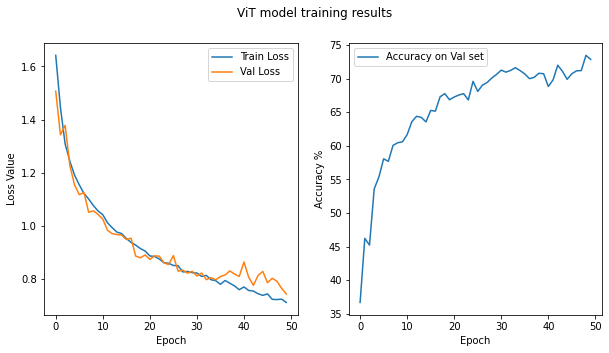

In [14]:
# Increase plot size
plt.rcParams["figure.figsize"] = [10, 5]

# Plots
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("ViT model training results")

x = range(len(train_losses))
ax1.plot(x, train_losses, label="Train Loss")
ax1.plot(x, valid_losses, label="Val Loss")
ax1.set_ylabel("Loss Value")
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(x, accuracies, label="Accuracy on Val set")
ax2.set_ylabel("Accuracy %")
ax2.set_xlabel("Epoch")
ax2.legend()

plt.show()
